## Motivation for this test:

From the paper of Transferability of optimal QAOA parameters between random graphs, it says we can do so by "iterating over all edges of initial graph and selecting nodes that are p edges away from the edge". From the paper " Connecting the Hamiltonian structure to the QAOA energy and Fourier landscape structure", an analysis of the cost landscape is made for 2-qubit terms or 1-qubit terms in a given Hamiltonian. It was found that the Structure of the Hamiltonian, which is basically a graph structure, influences the roughness of the cost landscape, leading to less local minima or less roughness (studied by taking the Fourier Analysis of peaks or valleys in the cost landscape) in the cost landscape, making it easier to optimize. There is the term "parameter concentration" which is also mentionned in the paper of parity of degree in regular graphs, whose optimal parameters are compatible for d-regular graphs with d having the same parity. This is why we want to construct d-regular graphs to optimize small instances (easier for QAOA), then transfer its optimal parameters to a larger compatible graph instance. 

The objective here is to build multiple d-regular graph generator from a random adjacency matrix, and save it, it could give information on wether there are regular-graphs in a larger graph and how many etc.: 


In [1]:
import networkx as nx 
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt
import sys

sys.path.append(r"C:\Users\harsh\quactography")
from quactography.graph.undirected_graph import Graph
from quactography.adj_matrix.io import load_graph
from quactography.adj_matrix.io import save_graph
from networkx import from_numpy_array 

### Simplest example of 3-regular graphs: complete graphs of 4 nodes:

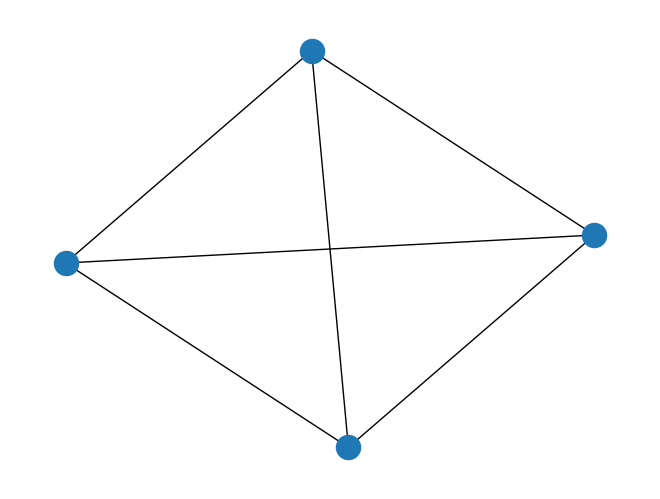

In [59]:
G = nx.random_regular_graph(3, 4)
nx.draw(G)

### Let's plot the Crossing fibers graph 5 bundles, and get its adjacency matrix :

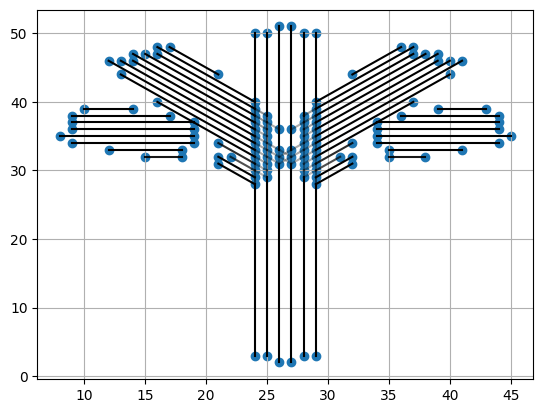

In [2]:
file = "graph.npz"
weighted_graph, node_indices, vol_dim = load_graph(file)


x, y = np.unravel_index(node_indices, vol_dim)
weighted_graph_triu = np.triu(weighted_graph)

# draw the graph
for it, node_row in enumerate(weighted_graph_triu):
    nb_adj = np.count_nonzero(node_row)
    if nb_adj > 0:
        w_all = node_row[node_row > 0]
        start_x, start_y = x[it], y[it]
        end_x = x[node_row > 0]
        end_y = y[node_row > 0]
        for vert_id in range(nb_adj):
            w = w_all[vert_id]
            alpha = np.clip(w * 0.9 + 0.1, 0.0, 1.0)
            plt.plot(
                [start_x, end_x[vert_id]],
                [start_y, end_y[vert_id]],
                color="black",
                alpha=alpha,
            )

plt.scatter(x, y)
plt.grid(True)

plt.savefig("graph_adj_mat.png")  # Save the plot as a PNG file
plt.show()

## Let's generate the most d-regular subgraphs from the large random adjacency matrix: 
### Steps: 
 1) Read rows and columns of numpy matrix, whole matrix needed. 
 2) Look at the number of non-zero element in the row : if length is >=d, then keep this node, select 3 non-zero element : i node
 3) For a non-zero element in that row chosen, check column index :j node 
 4) Go to the row of same index and check number of non zero elements
 5) If d-1 connexions: keep, else, look for another non-zero element from first row and repeat until found
 6) Change first row if nothing found... and repeat. 
 Then the 3-regular graph for nodes i and j is built, just like in the paper we found. 

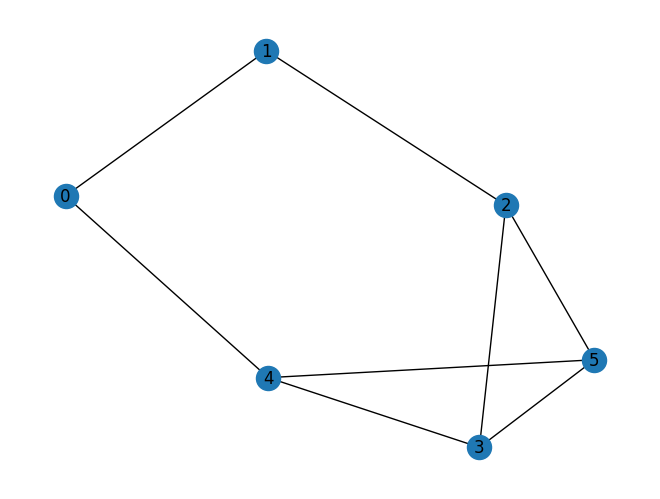

In [3]:
# PSEUDO-CODE: 
""" 
for columns, rows in numpy array(matrix) : 
Input: seed to start verifying if number of connexions sufficient (i node)
        take first row: verify if number of non-zero element is superior of equal to d
        if yes:
            keep first d non-zero element, 
        else: 
             go to next row: 
             restart loop
        take first non-zero term column index, go to that row, 
        if that row has more than d or d non-zero elements:
              keep d first non-zero elements.
        if not enough non-zero element:
              chose another non-zero element of row 1, take its column index, until d non-zero elements found for the corresponding row: 

Create a subgraph and sub-adjacency matrix to get a d-regular graph 
""" 

seed = 2 # user can change its value eventually , should be between 0 and n-1 for a n-nodes graph 
degree = 3 # user can change its value eventually, should be the degree of the regular graph the user wishes to decompose its larger graph into
 
# let's take a small toy-graph to test the code: 
adj_weighted_mat_toy = np.array([[0,1,0,0,1,0],
                                 [1,0,1,0,0,0],
                                 [0,1,0,1,0,1], 
                                 [0,0,1,0,1,1], 
                                 [1,0,0,1,0,1],
                                 [0,0,1,1,1,0]])

node_indices = [0,1,2,3,4,5]
vol_dim= (6,6) 
G = from_numpy_array(adj_weighted_mat_toy)
nx.draw(G, with_labels=True)
plt.show()



## Find all 3-regular graphs possible (thus without specifying a seed):

### Works for non-symetric matrices (for symetric matrices the information is doubled)


In [4]:

sub_graphs_possible_i_node = []

# Dictionary with keys being 3-degree i_node and values being non-zero terms in i'th row column index
# being a potential j node: 
sub_graphs_potential_j_node = {}

# Find 3-degree i_node: 
for (num_row, row) in enumerate(adj_weighted_mat_toy):
    
    # print('row',num_row, ':',row)
    nb_adj = np.count_nonzero(row)
    
    #Case 1: if we find a row that exactly the same number of non-zero elements as degree number: 
    if nb_adj == degree:
        sub_graphs_possible_i_node.append(num_row)   
        sub_graphs_potential_j_node[num_row] = []
    
    # # Case 2: if we find a row with more than d non-zero elements 
    # # (we would have to consider only d and leave out the rest):   
    # elif nb_adj > degree:
    #     # TO-DO  
    #     pass 
    
    # Case 3: if the number of non-zero elements is less than d, we don't consider that node at all: 
    else:
        sub_graphs_possible_i_node.append(None)
        print(' {} is not a d-degree node'.format(num_row))
# Test : 
# print('potential j nodes',sub_graphs_potential_j_node)
print(sub_graphs_possible_i_node)
# Find connexions of i_node: 
for i_node,(num_row, row) in zip(sub_graphs_possible_i_node,enumerate(adj_weighted_mat_toy)):
    if i_node != None:
        for possible_j_node_pos,value in enumerate(row):
            if value!= 0 :
                 
                sub_graphs_potential_j_node[num_row].append(possible_j_node_pos)
    
# Test: 
print('i nodes list: ',sub_graphs_possible_i_node)

# We must now find a way to verify if the j_nodes are 3-degree, 
# if yes than we have a 3-regular graph composed of node i and j: 

for list_node in sub_graphs_potential_j_node.values():
    for node in list_node:
        if node not in sub_graphs_possible_i_node:
            list_node.remove(node)
# print(sub_graphs_possible_i_node)
print('All possibilities of 3-regular graphs with key being ith node, and value a possible j node : \n',sub_graphs_potential_j_node)

print('\n Final result: 2-3, 2-5, 3-4 are possible 3 regular subgraphs in this example.')

 0 is not a d-degree node
 1 is not a d-degree node
[None, None, 2, 3, 4, 5]
i nodes list:  [None, None, 2, 3, 4, 5]
All possibilities of 3-regular graphs with key being ith node, and value a possible j node : 
 {2: [3, 5], 3: [2, 4, 5], 4: [3, 5], 5: [2, 3, 4]}

 Final result: 2-3, 2-5, 3-4 are possible 3 regular subgraphs in this example.


### Test with larger matrix (diffusion data) :

In [30]:
# degree = 4 
# adj_weighted_mat_toy = weighted_graph

# sub_graphs_possible_i_node = []

# # Dictionary with keys being 3-degree i_node and values being non-zero terms in i'th row column index
# # being a potential j node: 
# sub_graphs_potential_j_node = {}

# # Find 3-degree i_node: 
# for (num_row, row) in enumerate(adj_weighted_mat_toy):
    
#     # print('row',num_row, ':',row)
#     nb_adj = np.count_nonzero(row)
    
#     #Case 1: if we find a row that exactly the same number of non-zero elements as degree number: 
#     if nb_adj == degree:
#         sub_graphs_possible_i_node.append(num_row)   
#         sub_graphs_potential_j_node[num_row] = []
    
#     # # Case 2: if we find a row with more than d non-zero elements 
#     # # (we would have to consider only d and leave out the rest):   
#     # elif nb_adj > degree:
#     #     # TO-DO  
#     #     pass 
    
#     # Case 3: if the number of non-zero elements is less than d, we don't consider that node at all: 
#     else:
#         sub_graphs_possible_i_node.append(None)
#         print(' {} is not a d-degree node'.format(num_row))
# # Test : 
# # print('potential j nodes',sub_graphs_potential_j_node)
# print(sub_graphs_possible_i_node)
# # Find connexions of i_node: 
# for i_node,(num_row, row) in zip(sub_graphs_possible_i_node,enumerate(adj_weighted_mat_toy)):
#     if i_node != None:
#         for possible_j_node_pos,value in enumerate(row):
#             if value!= 0 :
                 
#                 sub_graphs_potential_j_node[num_row].append(possible_j_node_pos)
    
# # Test: 
# print('i nodes list: ',sub_graphs_possible_i_node)

# # We must now find a way to verify if the j_nodes are 3-degree, 
# # if yes than we have a 3-regular graph composed of node i and j: 

# for list_node in sub_graphs_potential_j_node.values():
#     for node in list_node:
#         if node not in sub_graphs_possible_i_node:
#             list_node.remove(node)
# # print(sub_graphs_possible_i_node)
# print('All possibilities of 3-regular graphs with key being ith node, and value a possible j node : \n',sub_graphs_potential_j_node)

# # print('\n Final result: 2-3, 2-5, 3-4 are possible 3 regular subgraphs in this example.')
import numpy as np
import matplotlib.pyplot as plt
from openqaoa.qaoa_components import QAOADescriptor, create_qaoa_variational_params
from openqaoa.backends import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import random_classical_hamiltonian
from qiskit.quantum_info import SparsePauliOp
# generate the mixer Hamiltonian
from openqaoa.qaoa_components import PauliOp, Hamiltonian
import numpy as np
paul_term = [
    PauliOp('III', (0, 1, 2)), 
    PauliOp('Z', (0,)), 
    PauliOp('Z', (1,)), 
    PauliOp('Z', (2,)),
    PauliOp('III', (0, 1, 2)), 
    PauliOp('ZZ', (0, 2)), 
    PauliOp('ZZ', (0, 1)), 
    PauliOp('ZZ', (1, 2))
]

coef_terms = [-2, 1, 0.5, 0.5, 6, 1, 1, -4]

cost_hamiltonian = Hamiltonian(paul_term, coef_terms, constant=0)
n_qubits =3
qubit_register = [0,1,2]


pauli_terms = [PauliOp('X',(i,)) for i in qubit_register]
pauli_coeffs = [1]*n_qubits
mixer_hamiltonian = Hamiltonian(pauli_terms,pauli_coeffs,constant=0)

qaoa_descriptor_p1 = QAOADescriptor(cost_hamiltonian, mixer_hamiltonian, p=1)
qaoa_descriptor_p2 = QAOADescriptor(cost_hamiltonian, mixer_hamiltonian, p=2)
variate_params_std = create_qaoa_variational_params(qaoa_descriptor_p1,'standard','ramp')
variate_params_fourier = create_qaoa_variational_params(qaoa_descriptor_p2,'fourier','ramp',q=1)

# call the device to use
device_qiskit = create_device(location = 'local', name = 'qiskit.qasm_simulator')

# initialize the backend with the device and circuit_params
backend_qiskit_p1 = get_qaoa_backend(qaoa_descriptor_p1, device_qiskit, n_shots = 500)
backend_qiskit_p2 = get_qaoa_backend(qaoa_descriptor_p2, device_qiskit, n_shots = 500)
# helper function to produce the cost landscape
def plot_cost_landscape(mixer_angle_iter, cost_angle_iter, variational_params, backend):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.

    Parameters
    ----------

    """
    cost_landscape = np.zeros((mixer_angle_iter.size,mixer_angle_iter.size),dtype=float)

    for i,mixer_angle in enumerate(mixer_angle_iter):
        for j,cost_angle in enumerate(cost_angle_iter):
            variational_params.update_from_raw([mixer_angle,cost_angle])
            cost_landscape[i,j] = backend.expectation(variational_params)

    return cost_landscape

In [31]:
# cost landscape for standard parameterization
gammas = np.linspace(-np.pi,np.pi,25)
betas = np.linspace(-np.pi/2,np.pi/2,25)

cost_landscape_std = plot_cost_landscape(betas, gammas, variate_params_std, backend_qiskit_p1)

# cost landscape for Fourier parameterization
us = np.linspace(0,2*np.pi,50)
vs = np.linspace(0,np.pi,50)

cost_landscape_fourier = plot_cost_landscape(vs, us, variate_params_fourier, backend_qiskit_p2)

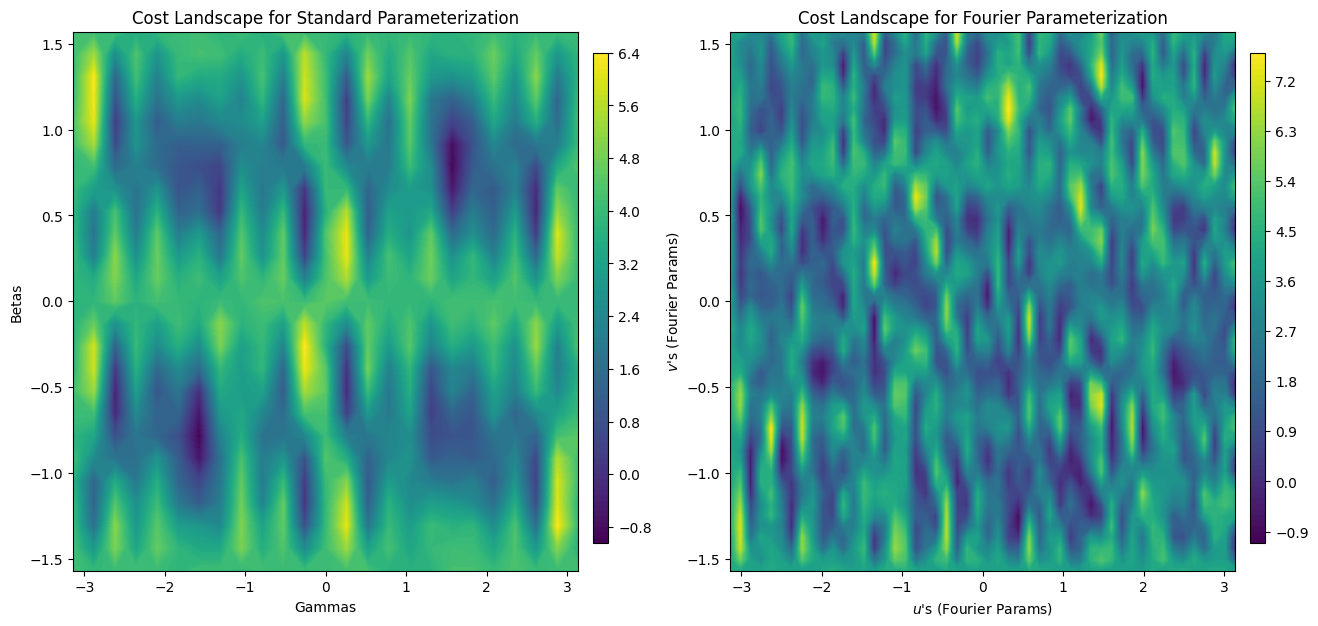

In [32]:
fig,axes = plt.subplots(1,2,sharex = False, sharey=False,figsize=(15,7),gridspec_kw={'wspace': 0.3})
cmap = 'viridis'

im_0 = axes[0].contourf(cost_landscape_std,cmap=cmap,levels=100,extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
axes[0].set_title('Cost Landscape for Standard Parameterization')
axes[0].set_xlabel('Gammas')
axes[0].set_ylabel('Betas')

cbar_ax = fig.add_axes([0.472, 0.15, 0.01, 0.7])
fig.colorbar(im_0, cax=cbar_ax)
im_1 = axes[1].contourf(cost_landscape_fourier,cmap=cmap,levels=100,extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
axes[1].set_title('Cost Landscape for Fourier Parameterization')
axes[1].set_xlabel("$u$'s (Fourier Params)")
axes[1].set_ylabel("$v$'s (Fourier Params)")

cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im_1, cax=cbar_ax)
plt.show()

### Now that we have all the different combinations of i-j node which corresponds to d-regular graphs, we must build a sub-graph: smaller adjacency matrix:

## Other sub-test with Fibercup: 

Must add file for the graph of Fibercup and define weighted_graph again: 

[]


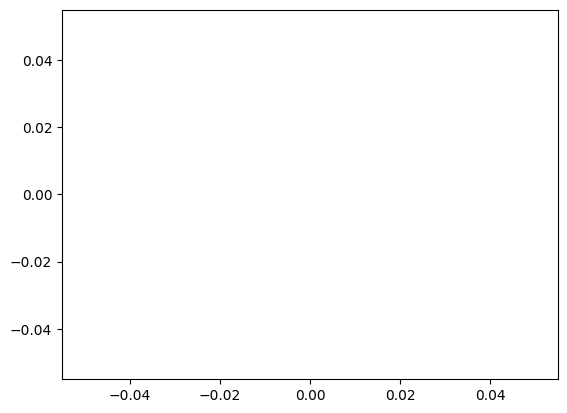

In [7]:

select_1 =230
select_2 =290
num_nodes = select_2-select_1
weighted_graph_selec = weighted_graph[select_1:select_2,select_1:select_2]
print(weighted_graph_selec)
weighted_graph_selec = np.triu(weighted_graph_selec)

x_selec = x[select_1:select_2]
y_selec = y[select_1:select_2]
# draw the graph
for it, node_row in enumerate(weighted_graph_selec):
    nb_adj = np.count_nonzero(node_row)
    if nb_adj > 0:
        w_all_selec = node_row[node_row > 0]
        start_x, start_y = x_selec[it], y_selec[it]
        end_x = x_selec[node_row > 0]
        end_y = y_selec[node_row > 0]
        for vert_id in range(nb_adj):
            w = w_all_selec[vert_id]
            alpha = np.clip(w * 0.9 + 0.1, 0.0, 1.0)
            plt.plot(
                [start_x, end_x[vert_id]],
                [start_y, end_y[vert_id]],
                color="black",
                alpha=alpha,
            )

plt.scatter(x_selec, y_selec)
plt.show()